# Evolutionary Simulators: From Chemostats to Chromosomes

---
**Nadav Ben Nun** &nbsp;|&nbsp; *Gresham Lab (NYU) · Selmecki Lab (UMN)*

---

Different biological questions — and different experimental systems — require different
computational models. This notebook traces five simulators developed for experimental
evolution.

| # | Paper | Model | System |
|---|-------|-------|--------|
| 1 | **Avecilla et al.** | 3-genotype Wright-Fisher | Chemostat (continuous culture) |
| 2 | **Avecilla et al.** | Chemostat ODE (Monod) | Chemostat (continuous culture) |
| 3 | **Chuong et al.** | 4-genotype Wright-Fisher | Discrete-generation batch |
| 4 | **De et al.** | 2-genotype Wright-Fisher | CNV reversion |
| 5 | **Zhou et al.** | Aneuploidy stability WF | Trisomic → diploid / LOH |

Each section follows the same structure:
1. **Empirical data** — what was measured
2. **Model** — equations and diagram
3. **Model fit** — simulations with $\theta + \mathcal{N}(0,\sigma)$ noise to replicate group dynamics

---
### Running on Google Colab

Upload the entire `tutorials/` folder to Google Drive, then open this notebook in Colab.
All data and code are bundled — no server connection required.


In [103]:
import sys, warnings, os
warnings.filterwarnings('ignore')

# evo_model.py lives in the same directory as this notebook
sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.integrate import odeint
from IPython.display import Image, display

# ── Plotting style ──────────────────────────────────────────────────────────
plt.rcParams.update({
    'font.size': 13, 'axes.titlesize': 14, 'axes.labelsize': 13,
    'xtick.labelsize': 11, 'ytick.labelsize': 11,
    'figure.dpi': 100,
    'axes.spines.top': False, 'axes.spines.right': False,
    'legend.frameon': False, 'figure.facecolor': 'white',
})

C = {
    'avecilla_wf':   '#E67E22',
    'avecilla_ode':  '#2980B9',
    'chuong':        '#27AE60',
    'de':            '#C0392B',
    'zhou':          '#8E44AD',
    'data':          '#2C3E50',
}
REP_COLORS = [cm.tab20(x) for x in np.linspace(0, 1, 12, endpoint=False)]

GENERATIONS = np.array([8, 21, 29, 37, 50, 58, 66, 79, 87, 95, 108, 116])

# ── Load empirical data ──────────────────────────────────────────────────────
ltr_df   = pd.read_csv('data/ltr.csv',   index_col=0)
lauer_df = pd.read_csv('data/lauer.csv', index_col=0)
ltr_df.columns   = ltr_df.columns.astype(int)
lauer_df.columns = lauer_df.columns.astype(int)
# Use only the 9 gln replicates (gln_01–gln_09); drop bc01/bc02
lauer_df = lauer_df.loc[[r for r in lauer_df.index if r.startswith('gln_')]]
LAUER_GEN = lauer_df.columns.values
LTR_GEN   = ltr_df.columns.values

def show_image(path, width=600):
    """Display a local image, or print a placeholder if not found."""
    if os.path.exists(path):
        display(Image(path, width=width))
    else:
        print(f"[Image not found: '{path}' — upload the diagram to the tutorials directory]")

def noisy_sims(simulator, theta, sigma, n=20, extra_kw=None):
    """
    Run `simulator` n times, each with theta perturbed by independent Gaussian noise.

    Each simulation draws  theta_i ~ N(theta, sigma)  and uses a different drift seed.
    The spread of the resulting trajectories reflects BOTH parameter variation across
    replicates AND within-replicate stochastic drift.

    Parameters
    ──────────
    simulator : callable  — the WF/ODE simulator function
    theta     : dict      — central parameter values  (tune to match data)
    sigma     : dict      — per-parameter noise std   (tune to match data spread)
    n         : int       — number of simulations
    extra_kw  : dict      — additional fixed kwargs (e.g. generation=...) not perturbed

    Returns: list of n simulation results
    """
    extra_kw = extra_kw or {}
    results  = []
    for i in range(n):
        rng = np.random.default_rng(i)
        theta_i = {k: v + rng.normal(0, sigma.get(k, 0)) for k, v in theta.items()}
        np.random.seed(i)
        results.append(simulator(**theta_i, **extra_kw))
    return results

print("✓ Setup complete")
print(f"  LTR data  : {ltr_df.shape[0]} replicates × {ltr_df.shape[1]} time points")
print(f"  Lauer data: {lauer_df.shape[0]} replicates × {lauer_df.shape[1]} time points")


✓ Setup complete
  LTR data  : 7 replicates × 12 time points
  Lauer data: 9 replicates × 11 time points


## 1. Avecilla et al. — Wright-Fisher Model

*(Avecilla et al. 2022, [PMC9140244](https://pmc.ncbi.nlm.nih.gov/articles/PMC9140244/))*

---

### The data: Lauer et al. chemostat experiment

*S. cerevisiae* was evolved in **glutamine-limited chemostats** for over 100 generations.
GAP1 CNV frequency was measured in 9 independent replicate populations by barcode sequencing.

- **9 replicate populations** (`gln_01` to `gln_09`)
- **Observable**: fraction of cells carrying a GAP1 CNV


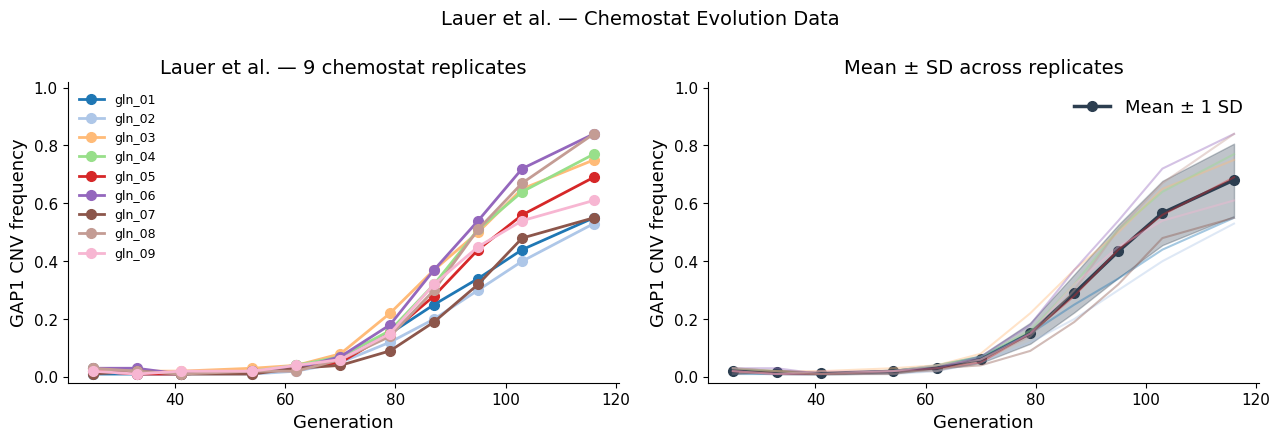

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
for j, (rep, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o-', color=REP_COLORS[j], ms=7, lw=2, label=rep)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('Lauer et al. — 9 chemostat replicates')
ax.set_ylim(-0.02, 1.02); ax.legend(fontsize=9)

ax = axes[1]
mean_l = lauer_df.mean(axis=0)
std_l  = lauer_df.std(axis=0)
ax.fill_between(LAUER_GEN, mean_l - std_l, mean_l + std_l, alpha=0.3, color=C['data'])
ax.plot(LAUER_GEN, mean_l, 'o-', color=C['data'], lw=2.5, ms=7, label='Mean ± 1 SD')
for j, (_, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, '-', color=REP_COLORS[j], alpha=0.4, lw=1.5)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('Mean ± SD across replicates')
ax.set_ylim(-0.02, 1.02); ax.legend()

plt.suptitle('Lauer et al. — Chemostat Evolution Data', fontsize=14)
plt.tight_layout(); plt.show()


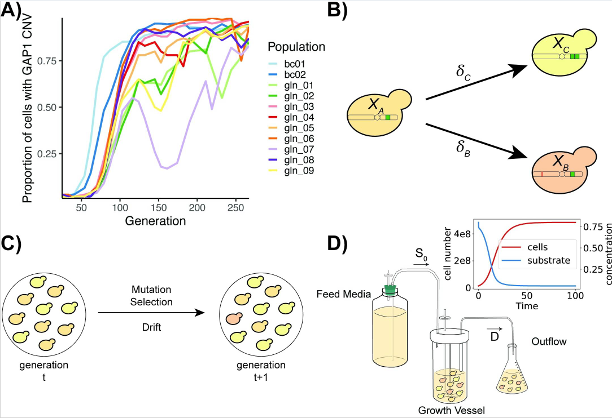

In [71]:
show_image('avecilla_wf_model.png')


### The model: 3-genotype Wright-Fisher

Two types of beneficial mutation arise from the ancestral genotype:
- A **GAP1 CNV** (amplification of the amino-acid permease gene)
- Other **beneficial mutations** (SNVs, other structural variants)

#### Genotypes

| Symbol | Genotype | Fitness |
|--------|----------|---------|
| $X_A$ | Ancestral (WT) | 1 |
| $X_C$ | GAP1 CNV | $1 + s_C$ |
| $X_B$ | Other beneficial mutation | $1 + s_B$ |

#### Discrete-generation update

**Mutation** (only ancestral cells mutate):
$$x_C^\dagger = x_A \delta_C + x_C, \quad x_B^\dagger = x_A \delta_B + x_B, \quad
  x_A^\dagger = (1 - \delta_C - \delta_B)\,x_A$$

**Selection**: $x_i^* = w_i x_i^\dagger / \bar{w}$

**Drift** ($N = 3.3 \times 10^8$):
$n_{t+1} \sim \mathrm{Multinomial}(N,\; x^*)$


In [72]:
def WF_Avecilla(log_delta_C, log_delta_B, s_C, s_B,
                generation, seed=None, N=int(3.3e8)):
    """
    Avecilla et al. 3-genotype Wright-Fisher simulator.

    Parameters
    ──────────
    log_delta_C : log10(CNV formation rate δ_C per generation)
    log_delta_B : log10(other-beneficial mutation rate δ_B per generation)
    s_C, s_B    : fitness advantages (linear scale)
    generation  : array of generation indices to return
    N           : effective population size (default 3.3 × 10^8)

    Returns: np.ndarray shape (len(generation), 3) — frequencies [x_A, x_C, x_B]
    """
    delta_C = 10 ** log_delta_C
    delta_B = 10 ** log_delta_B

    if seed is not None:
        np.random.seed(seed)

    w = np.array([1.0, 1.0 + s_C, 1.0 + s_B])
    M = np.array([
        [1 - delta_C - delta_B,  0,  0],
        [delta_C,                1,  0],
        [delta_B,                0,  1],
    ], dtype='float64')
    E = M @ np.diag(w)

    n = np.array([N, 0.0, 0.0])
    freqs = []
    for _ in range(int(generation.max()) + 1):
        freqs.append(n / n.sum())
        p = E @ (n / n.sum())
        p /= p.sum()
        n = np.random.multinomial(int(N), p).astype(float)

    return np.array(freqs)[generation.astype(int)]


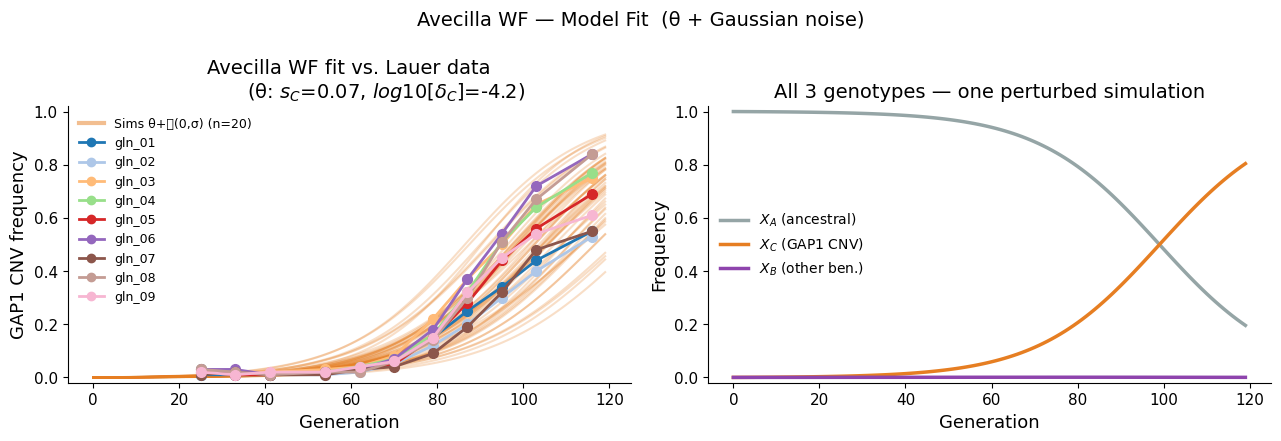

In [76]:
# ── Model fit: Avecilla WF vs. Lauer data ────────────────────────────────────
# Central theta (from Avecilla et al. / estimates) — adjust to improve the fit
THETA_AVE = dict(
    log_delta_C = -4.2,   # CNV formation rate
    log_delta_B = -5.0,   # other-beneficial rate
    s_C         =  0.07,  # CNV fitness advantage
    s_B         =  0.001, # other-beneficial fitness advantage
)
# Per-parameter noise std — controls how much replicates differ from each other
SIGMA_AVE = dict(
    log_delta_C = 0.2,
    log_delta_B = 0.2,
    s_C         = 0.005,
    s_B         = 0.005,
)

GEN_AVE = np.arange(120)
trajs   = noisy_sims(WF_Avecilla, THETA_AVE, SIGMA_AVE, n=50,
                     extra_kw=dict(generation=GEN_AVE))

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Panel A: simulation envelope + data
ax = axes[0]
for traj in trajs:
    ax.plot(GEN_AVE, traj[:, 1], lw=1.5, alpha=0.25, color=C['avecilla_wf'])
for j, (rep, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o-', color=REP_COLORS[j], ms=7, lw=2,
            label=rep, zorder=5)
from matplotlib.lines import Line2D
ax.legend(handles=[
    Line2D([0],[0], color=C['avecilla_wf'], lw=3, alpha=0.5,
           label=f'Sims θ+𝒩(0,σ) (n=20)'),
] + [Line2D([0],[0], color=REP_COLORS[j], marker='o', ms=6, lw=2, label=r)
     for j, r in enumerate(lauer_df.index)], fontsize=9)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')

ax.set_title(f'Avecilla WF fit vs. Lauer data\n\
            (θ: $s_C$={THETA_AVE["s_C"]}, $log10[δ_C]$={THETA_AVE["log_delta_C"]})')
ax.set_ylim(-0.02, 1.02)

# Panel B: all 3 genotypes in one perturbed replicate
ax = axes[1]
rng = np.random.default_rng(0)
theta_ex = {k: v + rng.normal(0, SIGMA_AVE.get(k, 0)) for k, v in THETA_AVE.items()}
traj_ex  = WF_Avecilla(**theta_ex, generation=GEN_AVE, seed=0)
ax.plot(GEN_AVE, traj_ex[:, 0], lw=2.5, color='#95A5A6', label='$X_A$ (ancestral)')
ax.plot(GEN_AVE, traj_ex[:, 1], lw=2.5, color=C['avecilla_wf'], label='$X_C$ (GAP1 CNV)')
ax.plot(GEN_AVE, traj_ex[:, 2], lw=2.5, color='#8E44AD',  label='$X_B$ (other ben.)')
ax.set_xlabel('Generation'); ax.set_ylabel('Frequency')
ax.set_title('All 3 genotypes — one perturbed simulation')
ax.legend(fontsize=10); ax.set_ylim(-0.02, 1.02)

plt.suptitle('Avecilla WF — Model Fit  (θ + Gaussian noise)', fontsize=14)
plt.tight_layout(); plt.show()


## 2. Avecilla et al. — Chemostat ODE Model

---

### Why an ODE for chemostat evolution?

In a **chemostat**, cells grow continuously — not in discrete synchronized generations.
The ODE models nutrient-limited growth explicitly via **Monod kinetics**.

### Three genotypes with mutation

$$\frac{dX_A}{dt} = X_A\!\left(\mu_A - D\right) - (\delta_C + \delta_B)\,X_A$$
$$\frac{dX_C}{dt} = X_C\!\left(\mu_C - D\right) + \delta_C\,X_A$$
$$\frac{dX_B}{dt} = X_B\!\left(\mu_B - D\right) + \delta_B\,X_A$$
$$\frac{dS}{dt} = D(S_0 - S) - \frac{1}{Y}\!\left(X_A\mu_A + X_C\mu_C + X_B\mu_B\right)$$

with Monod kinetics $\mu_i = r_i S / (S + k)$ and $r_i = r_A(1 + s_i \ln 2)$.

### Parameters (Avecilla et al., Table 2)

| Symbol | Value | Meaning |
|--------|-------|---------|
| $D$ | 0.12 h⁻¹ | Dilution rate |
| $S_0$ | 0.8 mM | Influent glutamine |
| $k$ | 0.103 mM | Half-saturation (all genotypes) |
| $Y$ | 3.24 × 10⁷ cells mL⁻¹ mM⁻¹ | Yield |
| $r_A$ | 0.166 h⁻¹ | Ancestral max growth rate |

**Time axis**: hours. Conversion: 1 WF generation $= 1.5$ h (empirical chemostat value).


In [77]:
# Avecilla et al. Table 2 constants
D_AVE  = 0.12      # h⁻¹  dilution rate
S0_AVE = 0.8       # mM   influent substrate
K_AVE  = 0.103     # mM   half-saturation
Y_AVE  = 3.24e7    # cells/mL/mM  yield
R_A    = 0.166     # h⁻¹  ancestral max growth rate

GEN_TO_HOURS = 1.5   # hours per WF generation (empirical chemostat value)


def WF_Avecilla_ODE(log_delta_C, log_delta_B, s_C, s_B,
                    D=D_AVE, S0=S0_AVE, k=K_AVE, Y=Y_AVE, r_A=R_A,
                    t_max=700.0, n_points=1000):
    """
    Avecilla et al. chemostat ODE — 3 competing genotypes with mutation.

    Parameters use the same WF convention (per-generation s and δ), converted to per-hour:
        delta_per_hr = 10**log_delta / GEN_TO_HOURS
        r_C = r_A * (1 + s_C / (D * GEN_TO_HOURS))   # exact at steady state

    Returns: t_grid (hours), freqs shape (n_points, 3) — [x_A, x_C, x_B]
    """
    # Consistent with WF: at chemostat steady state, per-generation advantage = s_C
    # mu_C - mu_A = s_C / GEN_TO_HOURS  →  r_C = r_A * (1 + s_C/(D*GEN_TO_HOURS))
    r_C = r_A * (1 + s_C / (D * GEN_TO_HOURS))
    r_B = r_A * (1 + s_B / (D * GEN_TO_HOURS))
    # Per-hour mutation rate: delta_per_hr = delta_per_gen / GEN_TO_HOURS
    delta_C = 10**log_delta_C / GEN_TO_HOURS
    delta_B = 10**log_delta_B / GEN_TO_HOURS

    S_ss = D * k / (r_A - D)
    X_ss = Y * (S0 - S_ss)

    def odes(y, t):
        X_A, X_C, X_B, S = y
        S   = max(S,   1e-12)
        X_A = max(X_A, 0.0); X_C = max(X_C, 0.0); X_B = max(X_B, 0.0)
        mu_A = r_A * S / (S + k)
        mu_C = r_C * S / (S + k)
        mu_B = r_B * S / (S + k)
        dX_A = X_A * (mu_A - D) - (delta_C + delta_B) * X_A
        dX_C = X_C * (mu_C - D) + delta_C * X_A
        dX_B = X_B * (mu_B - D) + delta_B * X_A
        dS   = D * (S0 - S) - (X_A * mu_A + X_C * mu_C + X_B * mu_B) / Y
        return [dX_A, dX_C, dX_B, dS]

    t_grid = np.linspace(0, t_max, n_points)
    sol    = np.clip(odeint(odes, [X_ss, 0.0, 0.0, S_ss], t_grid), 0, None)
    X_tot  = sol[:, :3].sum(axis=1, keepdims=True)
    freqs  = sol[:, :3] / np.where(X_tot > 0, X_tot, 1)
    return t_grid, freqs


### Translating the ODE to WF language — and why it matters for inference

The ODE and WF share **the same parameters** (Fig below). The translation is:

| ODE parameter | WF parameter | Relationship |
|---------------|-------------|--------------|
| $r_C$ (max growth rate of CNV) | $s_C$ (selection coefficient) | $s_C = (r_C - r_A)/(r_A \ln 2)$ |
| $\delta_C^{\text{hr}}$ (per-hour mutation rate) | $\delta_C^{\text{gen}}$ (per-generation) | $\delta_C^{\text{gen}} = \delta_C^{\text{hr}} \cdot \ln 2 / D$ |
| Continuous time $t$ (hours) | Discrete generation $g$ | $g = t \cdot D / \ln 2$ |
| Total cells $= X_{ss} \times V$ | Effective population size $N$ | $N = Y(S_0 - S_{ss}) \times V$ |

**Consequence:** the Avecilla WF model IS the discrete-generation approximation of the ODE.
The Lauer data is measured in **generations**, so the WF model directly matches the time axis.

**For inferring the mutation rate** from Lauer data:
> Use `WF_Avecilla` with SBI — the posterior on `log_delta_C` is the per-generation
> CNV mutation rate. Convert to per-hour via $\delta^{\text{hr}} = 10^{\delta_C} \cdot D / \ln 2$.

The ODE adds nutrient dynamics ($S$) which matter for mechanistic understanding of
*why* selection coefficients have particular values — but for **parameter inference**
from population-frequency data, the WF is sufficient and faster to simulate.


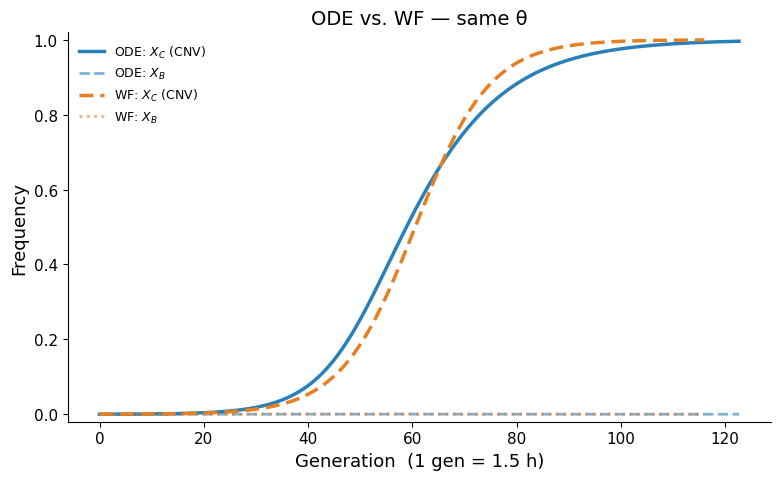

1 WF generation = 1.5 h
s_C = 0.15  →  r_C = 0.3043 h⁻¹  (steady-state advantage: 0.1500 per gen ≈ s_C)
δ_C = 10^-4.5 per gen  →  2.11e-05 h⁻¹ in ODE


In [79]:
# ── ODE vs WF: same WF parameters, generation axis ───────────────────────────
THETA_ODE = dict(log_delta_C=-4.5, log_delta_B=-5.0, s_C=0.15, s_B=0.001)

lauer_hours = LAUER_GEN * GEN_TO_HOURS
t_grid, freqs_ode = WF_Avecilla_ODE(**THETA_ODE, t_max=lauer_hours[-1] + 10)

gen_range = np.arange(int(LAUER_GEN[-1]) + 1)
traj_wf   = WF_Avecilla(**THETA_ODE, generation=gen_range, seed=42)

fig, ax = plt.subplots(figsize=(8, 5))

gen_axis = t_grid / GEN_TO_HOURS
ax.plot(gen_axis, freqs_ode[:, 1], lw=2.5, color=C['avecilla_ode'],
        label='ODE: $X_C$ (CNV)')
ax.plot(gen_axis, freqs_ode[:, 2], lw=2,   color=C['avecilla_ode'], ls='--',
        label='ODE: $X_B$', alpha=0.6)
ax.plot(gen_range, traj_wf[:, 1], lw=2.5, color=C['avecilla_wf'],
        ls=(0, (4, 2)), label='WF: $X_C$ (CNV)')
ax.plot(gen_range, traj_wf[:, 2], lw=2,   color=C['avecilla_wf'], ls=':',
        label='WF: $X_B$', alpha=0.6)

ax.set_xlabel(f'Generation  (1 gen = {GEN_TO_HOURS} h)')
ax.set_ylabel('Frequency')
ax.set_title('ODE vs. WF — same θ')
ax.legend(fontsize=9); ax.set_ylim(-0.02, 1.02)
plt.tight_layout(); plt.show()

print(f"1 WF generation = {GEN_TO_HOURS} h")
r_C_check = R_A * (1 + THETA_ODE['s_C'] / (D_AVE * GEN_TO_HOURS))
print(f"s_C = {THETA_ODE['s_C']}  →  r_C = {r_C_check:.4f} h⁻¹  "
      f"(steady-state advantage: {(r_C_check - R_A)*D_AVE/R_A*GEN_TO_HOURS:.4f} per gen ≈ s_C)")
print(f"δ_C = 10^{THETA_ODE['log_delta_C']} per gen  →  "
      f"{10**THETA_ODE['log_delta_C'] / GEN_TO_HOURS:.2e} h⁻¹ in ODE")


## 3. Chuong et al. — 4-Genotype Wright-Fisher

*(Chuong et al. 2025)*

---

### The data: LTRΔ discrete-generation evolution

*S. cerevisiae* was evolved in **discrete batch culture** for 116 generations.
Unlike the Avecilla chemostat, populations were passaged at fixed generation intervals.

- **7 replicate populations**
- **12 discrete generation time points**: [8, 21, 29, 37, 50, 58, 66, 79, 87, 95, 108, 116]
- **Observable**: GAP1 CNV⁺ frequency


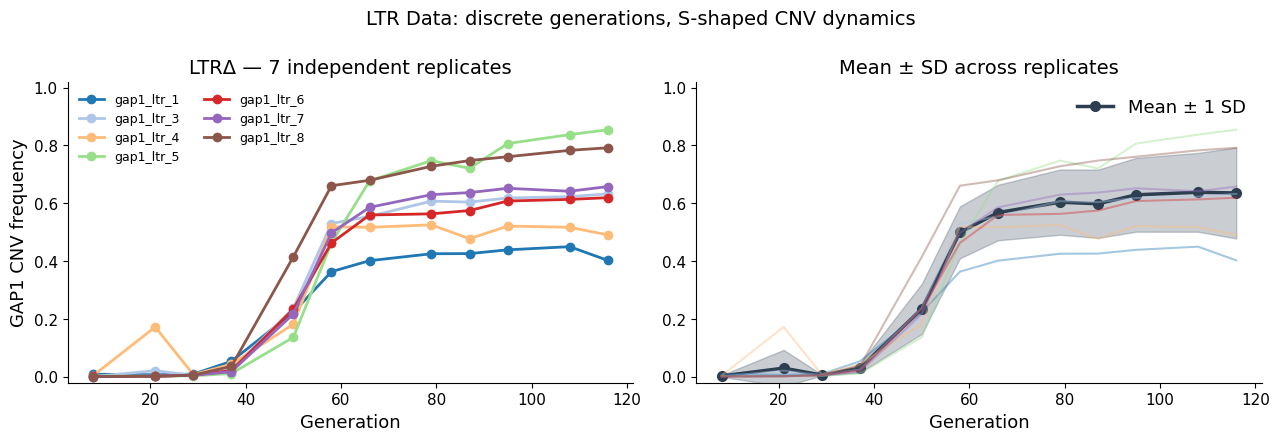

Non-zero CNV at generation 8:  mean=0.003 ± 0.003


In [80]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
for j, (strain, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o-', color=REP_COLORS[j], ms=6, lw=2, label=strain)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title('LTRΔ — 7 independent replicates')
ax.set_ylim(-0.02, 1.02); ax.legend(fontsize=9, ncol=2)

ax = axes[1]
mean_t = ltr_df.mean(axis=0)
std_t  = ltr_df.std(axis=0)
ax.fill_between(LTR_GEN, mean_t - std_t, mean_t + std_t, alpha=0.25, color=C['data'])
ax.plot(LTR_GEN, mean_t, 'o-', color=C['data'], lw=2.5, ms=7, label='Mean ± 1 SD')
for j, (_, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, '-', color=REP_COLORS[j], alpha=0.4, lw=1.5)
ax.set_xlabel('Generation'); ax.set_title('Mean ± SD across replicates')
ax.set_ylim(-0.02, 1.02); ax.legend()

plt.suptitle('LTR Data: discrete generations, S-shaped CNV dynamics', fontsize=14)
plt.tight_layout(); plt.show()

print(f"Non-zero CNV at generation 8:  "
      f"mean={ltr_df[8].mean():.3f} ± {ltr_df[8].std():.3f}")


### Why Avecilla models don't fit LTR data

1. **Non-zero CNV at generation 8** — pre-existing CNV pool absent from Avecilla WF
2. **Different N** — chemostat N = 3.3×10⁸ vs LTR N ≈ 10⁷; drift is stronger here
3. **Chemostat ODE** — wrong time units and wrong population dynamics for batch culture


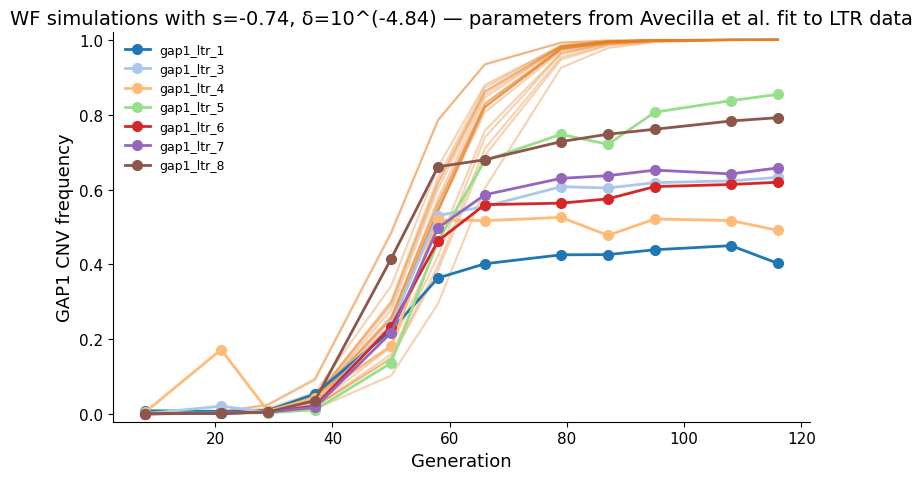

In [81]:
# Simulate with s=-0.74, delta=-4.84 in the wf model from avecilla
THETA_LTR = dict(log_delta_C=-4.84, log_delta_B=-5.0, s_C=10**(-0.74), s_B=0.001)
trajs_ltr = noisy_sims(WF_Avecilla, THETA_LTR, SIGMA_AVE, n=20,
                         extra_kw=dict(generation=LTR_GEN))
fig, ax = plt.subplots(figsize=(8, 5))
for traj in trajs_ltr:
    ax.plot(LTR_GEN, traj[:, 1], lw=1.5, alpha=0.35, color=C['avecilla_wf'])
for j, (rep, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o-', color=REP_COLORS[j], ms=7, lw=2,
            label=rep, zorder=5)
ax.legend(fontsize=9)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV frequency')
ax.set_title(f'WF simulations with s=-0.74, δ=10^(-4.84) — parameters from Avecilla et al. fit to LTR data')
ax.set_ylim(-0.02, 1.02); plt.tight_layout(); plt.show()

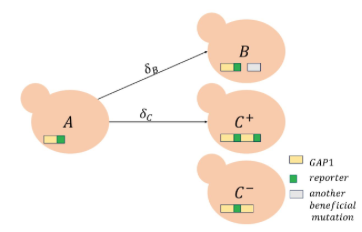

In [86]:
show_image('chuong_wf_model.png')


### The model: Chuong et al. 4-genotype Wright-Fisher

Key extension over the Avecilla WF:

**CNV⁻ pool** ($X_{C^-}$): pre-existing CNV cells explain non-zero CNV at generation 8

#### Genotypes

| Index | Genotype | Fitness | Initial frequency |
|-------|----------|---------|-------------------|
| 0 | WT (wild-type) | 1 | $1 - \varphi$ |
| 1 | CNV⁺ (new CNV) | $1 + s$ | $\approx 0$ (arises by mutation) |
| 2 | CNV⁻ (pre-existing) | $1 + s$ | $\varphi$ |
| 3 | SNV (point mutant) | $1 + s_{\text{snv}}$ | $\approx 0$ |

$$M = \begin{pmatrix}
1-\delta-\mu_{\text{snv}} & 0 & 0 & 0 \\
\delta & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\mu_{\text{snv}} & 0 & 0 & 1
\end{pmatrix}, \quad E = M \cdot \text{diag}(w), \quad
n_{t+1} \sim \mathrm{Multinomial}(N,\; E\,p_t / |E p_t|)$$

$N = 3.3\cdot10^8$


In [87]:
S_SNV  = 1e-3
M_SNV  = 1e-5
N_CHU  = int(3.3e8)


def WF_Chuong(log_s, log_m, log_p0, seed=None):
    """
    Chuong et al. 4-genotype Wright-Fisher simulator.

    Parameters (log₁₀ scale)
    ────────────────────────
    log_s   : log10(CNV fitness benefit s)
    log_m   : log10(CNV mutation rate δ, WT→CNV⁺)
    log_p0  : log10(initial CNV⁻ fraction φ)

    Returns: np.array length 12 — CNV⁺ frequency at GENERATIONS
    """
    s, m, p0 = 10 ** np.array([log_s, log_m, log_p0])

    if seed is not None:
        np.random.seed(seed)

    w = np.array([1.0, 1.0 + s, 1.0 + s, 1.0 + S_SNV])
    M = np.array([
        [1 - m - M_SNV,  0,  0,  0],
        [m,              1,  0,  0],
        [0,              0,  1,  0],
        [M_SNV,          0,  0,  1],
    ], dtype='float64')
    E = M @ np.diag(w)

    n    = np.zeros(4)
    n[0] = N_CHU * (1 - p0)
    n[2] = N_CHU * p0

    cnv_freq = []
    for _ in range(int(GENERATIONS.max()) + 1):
        cnv_freq.append(n[1] / N_CHU)
        p = E @ (n / N_CHU); p /= p.sum()
        n = np.random.multinomial(N_CHU, p).astype(float)

    return np.array(cnv_freq)[GENERATIONS]


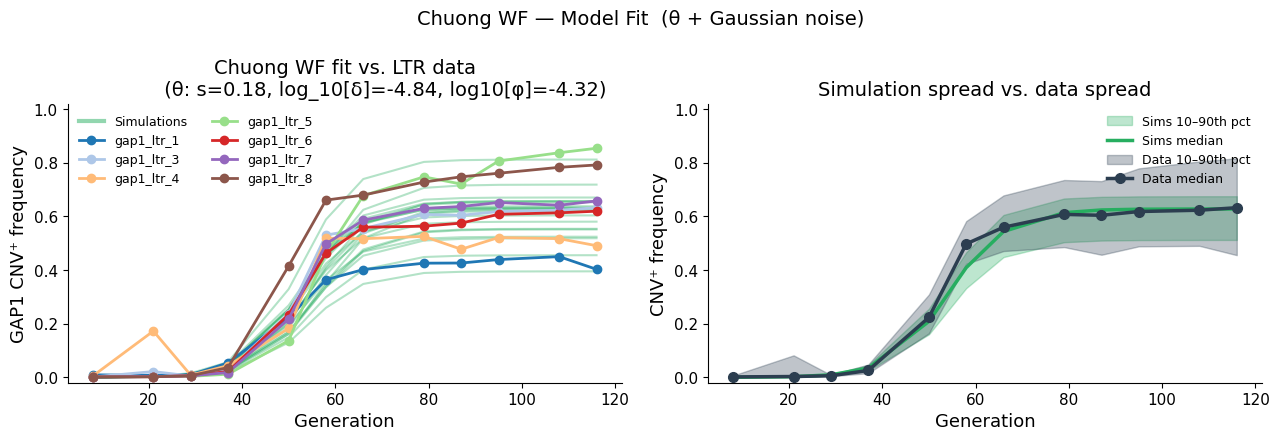

In [98]:
# ── Model fit: Chuong WF vs. LTR data ────────────────────────────────────────
THETA_CHU = dict(log_s=-0.74, log_m=-4.84, log_p0=-4.32)
SIGMA_CHU = dict(
    log_s  = 0.005,   
    log_m  = 0.1,    
    log_p0 = 0.1,
)

trajs_chu = noisy_sims(WF_Chuong, THETA_CHU, SIGMA_CHU, n=20)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Panel A: simulation envelope vs data
ax = axes[0]
for traj in trajs_chu:
    ax.plot(GENERATIONS, traj, lw=1.5, alpha=0.35, color=C['chuong'])
for j, (strain, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o-', color=REP_COLORS[j], ms=6, lw=2,
            label=strain, zorder=5)
from matplotlib.lines import Line2D
ax.legend(handles=[
    Line2D([0],[0], color=C['chuong'], lw=3, alpha=0.5, label='Simulations'),
] + [Line2D([0],[0], color=REP_COLORS[j], marker='o', ms=6, lw=2, label=r)
     for j, r in enumerate(ltr_df.index)], fontsize=9, ncol=2)
ax.set_xlabel('Generation'); ax.set_ylabel('GAP1 CNV⁺ frequency')
ax.set_title(f'Chuong WF fit vs. LTR data\n\
             (θ: s={10**THETA_CHU["log_s"]:.2f}, log_10[δ]={THETA_CHU["log_m"]}, log10[φ]={THETA_CHU["log_p0"]})')
ax.set_ylim(-0.02, 1.02)

# Panel B: simulation spread vs data spread
ax = axes[1]
sim_arr  = np.array(trajs_chu)
data_arr = ltr_df.values
ax.fill_between(GENERATIONS,
                np.percentile(sim_arr, 10, axis=0),
                np.percentile(sim_arr, 90, axis=0),
                alpha=0.3, color=C['chuong'], label='Sims 10–90th pct')
ax.plot(GENERATIONS, np.median(sim_arr, axis=0), lw=2.5, color=C['chuong'],
        label='Sims median')
ax.fill_between(LTR_GEN,
                np.percentile(data_arr, 10, axis=0),
                np.percentile(data_arr, 90, axis=0),
                alpha=0.3, color=C['data'], label='Data 10–90th pct')
ax.plot(LTR_GEN, np.median(data_arr, axis=0), 'o-', lw=2.5, color=C['data'],
        ms=7, label='Data median')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV⁺ frequency')
ax.set_title('Simulation spread vs. data spread')
ax.set_ylim(-0.02, 1.02); ax.legend(fontsize=9)

plt.suptitle('Chuong WF — Model Fit  (θ + Gaussian noise)', fontsize=14)
plt.tight_layout(); plt.show()


## 4. De et al. — 2-Genotype Wright-Fisher

---

### The data: CNV fluorescent reporter assay

De et al. used **fluorescent reporter strains** to track CNV copy number dynamics.
The `Multicopy_mCitrine` column tracks cells with amplified (multicopy) GAP1 reporters.

- **Key strain**: DGY1886
- **Observable**: `Multicopy_mCitrine` (%) — fraction of cells with amplified CNV
- **Note**: CNV starts **common** and **declines** as revertants take over


In [106]:
de_df

,Generation,Strain,0copy_mCherry,1copy_mCherry,Multicopy_mCherry,0copy_mCitrine,1copy_mCitrine,Multicopy_mCitrine
0,3,DGY1_1,99.97,0.03,0.00,100.00,0.00,0.00
1,3,DGY1_2,99.91,0.09,0.00,99.96,0.00,0.00
2,3,DGY1_3,99.78,0.09,0.00,99.91,0.01,0.00
3,3,DGY500_1,99.37,0.12,0.00,0.04,85.80,13.32
4,3,DGY500_2,99.03,0.21,0.00,0.06,80.63,17.94
...,...,...,...,...,...,...,...,...
975,219,DGY2755_4,0.19,88.96,9.41,0.17,77.30,25.03
976,219,DGY2769_1,0.37,14.02,84.78,0.15,94.73,6.13
977,219,DGY2769_2,0.24,3.90,95.49,0.17,94.58,6.12
978,219,DGY2769_3,0.07,14.88,84.72,0.03,92.01,9.56


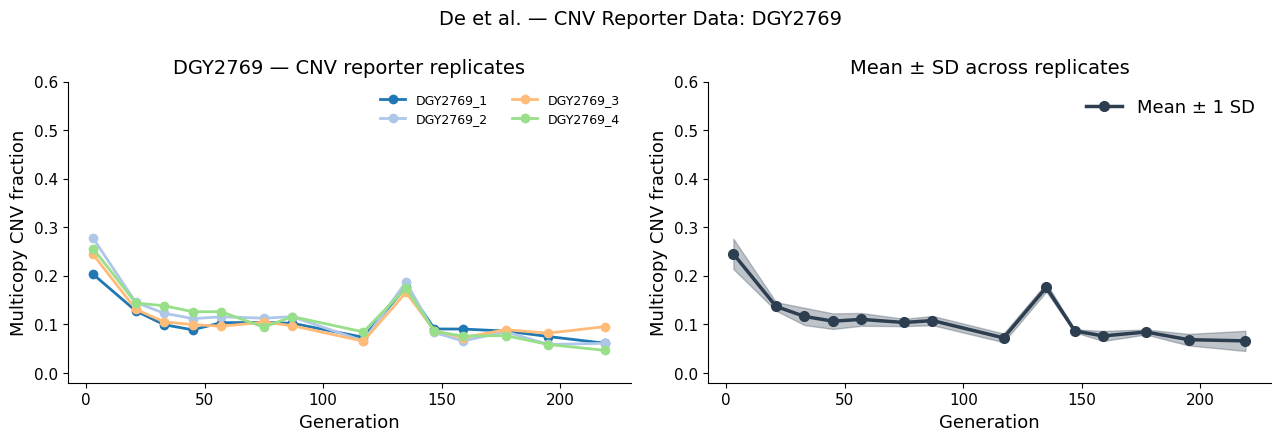

In [107]:
de_df = pd.read_csv('data/Evolution2_Dynamics_PercentReporters.csv')
strain_focus = 'DGY2769'
de_sub = de_df[de_df['Strain'].str.startswith(strain_focus)].copy()
de_sub['cnv_frac'] = de_sub['Multicopy_mCitrine '].astype(float) / 100.0

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['cnv_frac'], 'o-',
            color=REP_COLORS[j % 12], ms=6, lw=2, label=rep)
ax.set_xlabel('Generation'); ax.set_ylabel('Multicopy CNV fraction')
ax.set_title(f'{strain_focus} — CNV reporter replicates')
ax.legend(fontsize=9, ncol=2); ax.set_ylim(-0.02, 0.6)

ax = axes[1]
mean_de = de_sub.groupby('Generation')['cnv_frac'].mean()
std_de  = de_sub.groupby('Generation')['cnv_frac'].std()
ax.fill_between(mean_de.index, mean_de - std_de, mean_de + std_de,
                alpha=0.3, color=C['data'])
ax.plot(mean_de.index, mean_de, 'o-', color=C['data'], lw=2.5, ms=7, label='Mean ± 1 SD')
ax.set_xlabel('Generation'); ax.set_ylabel('Multicopy CNV fraction')
ax.set_title('Mean ± SD across replicates')
ax.set_ylim(-0.02, 0.6); ax.legend()

plt.suptitle(f'De et al. — CNV Reporter Data: {strain_focus}', fontsize=14)
plt.tight_layout(); plt.show()


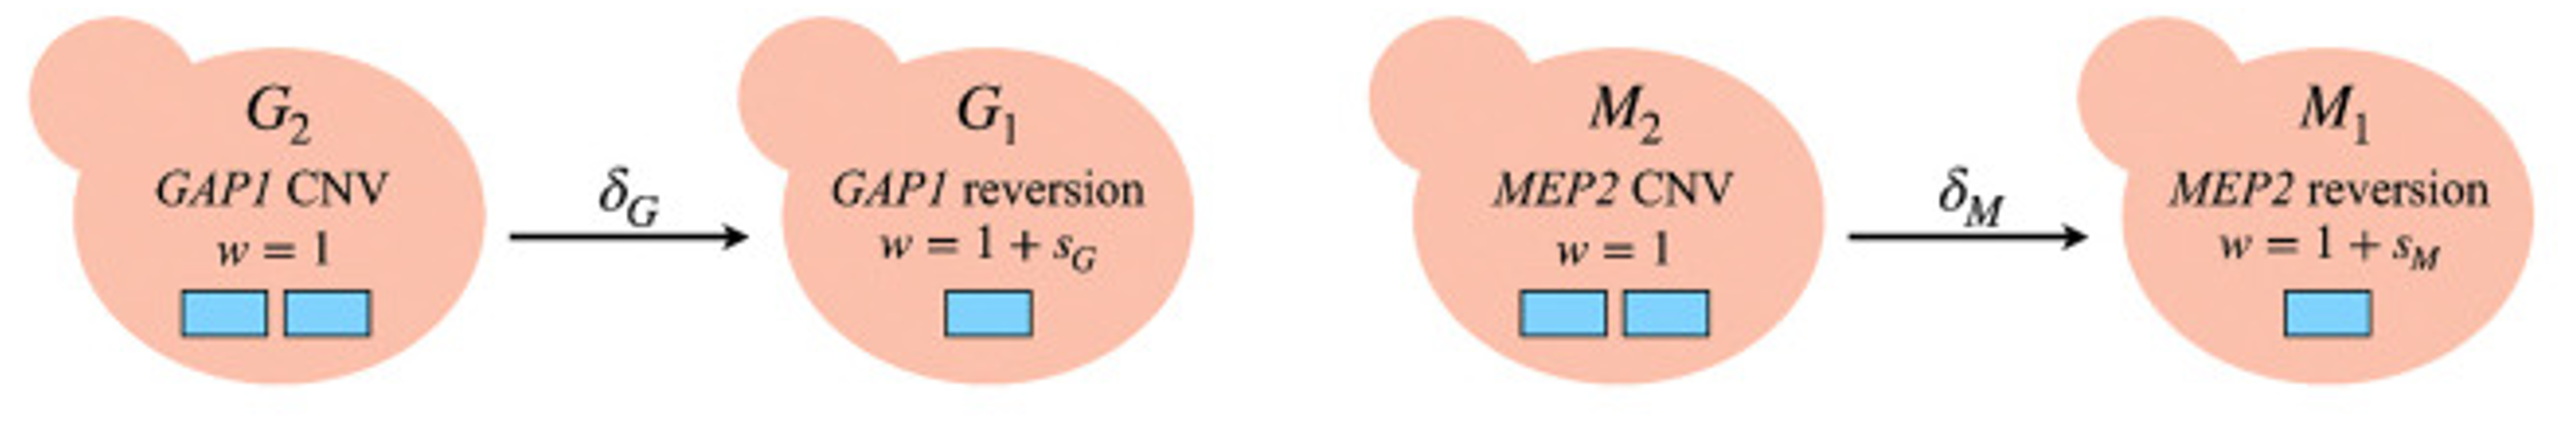

In [105]:
show_image('de_et_al_model.png')


### The model: De et al. 2-genotype WF (CNV reversion)

Asks the **opposite question** from Chuong: *How fast does an existing CNV revert?*

| Genotype | Fitness | Starts at |
|----------|---------|-----------|
| CNV (amplified) | 1 | $\sim 100\%$ |
| non-CNV (revertant) | $1 + s$ | rare ($\varphi$) |

Mutation direction: CNV → non-CNV at rate $\delta$ (reversion).

$$M = \begin{pmatrix} 1 - \delta & 0 \\ \delta & 1 \end{pmatrix}, \quad
E = M \cdot \text{diag}(1,\, 1+s), \quad N = 1.9 \times 10^6$$


In [102]:
def WF_De(log_s, log_m, log_p0, generation, seed=None, N=int(1.9e6)):
    """
    De et al. 2-genotype WF (CNV reversion).
    Genotype 0 = CNV (common), genotype 1 = non-CNV revertant (rare, fitness 1+s).
    Returns: np.array — CNV frequency at each generation.
    """
    s, m, p0 = 10 ** np.array([log_s, log_m, log_p0])
    if seed is not None:
        np.random.seed(seed)

    E = np.array([[1 - m, 0], [m, 1]], dtype='float64') @ np.diag([1.0, 1.0 + s])

    n = np.array([N * (1 - p0), N * p0])
    cnv_freq = []
    for _ in range(int(generation.max()) + 1):
        cnv_freq.append(n[0] / N)
        p = E @ (n / N); p /= p.sum()
        n = np.random.multinomial(N, p).astype(float)

    return np.array(cnv_freq)[generation.astype(int)]


In [101]:
# ── Model fit: De et al. WF vs. reporter data ────────────────────────────────
max_gen_de = int(de_sub['Generation'].max()) + 1
GEN_DE     = np.arange(max_gen_de)

THETA_DE = dict(log_s=-1.5, log_m=-4.5, log_p0=-2.0)
SIGMA_DE = dict(
    log_s  = 0.25,
    log_m  = 0.5,
    log_p0 = 0.4,
)

trajs_de = noisy_sims(WF_De, THETA_DE, SIGMA_DE, n=20,
                      extra_kw=dict(generation=GEN_DE))

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

ax = axes[0]
for traj in trajs_de:
    ax.plot(GEN_DE, traj, lw=1.5, alpha=0.3, color=C['de'])
for j, (rep, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['cnv_frac'], 'o-',
            color=REP_COLORS[j % 12], ms=6, lw=2, zorder=5, label=rep)
from matplotlib.lines import Line2D
ax.legend(handles=[
    Line2D([0],[0], color=C['de'], lw=3, alpha=0.5, label='Sims θ+𝒩(0,σ) (n=20)'),
    Line2D([0],[0], color='grey', marker='o', ms=6, lw=2, label='DGY1886 data'),
], fontsize=10)
ax.set_xlabel('Generation'); ax.set_ylabel('CNV frequency')
ax.set_title(f'De et al. WF fit vs. reporter data\n\
             (θ: s={10**THETA_DE["log_s"]:.2f}, log_10[δ]={THETA_DE["log_m"]}, log10[φ]={THETA_DE["log_p0"]})')
ax.set_ylim(-0.02, 0.7)

ax = axes[1]
sim_arr  = np.array(trajs_de)
gens_emp = sorted(de_sub['Generation'].unique())
data_arr = np.array([de_sub[de_sub['Generation'] == g]['cnv_frac'].values
                     for g in gens_emp]).T
ax.fill_between(GEN_DE,
                np.percentile(sim_arr, 10, axis=0),
                np.percentile(sim_arr, 90, axis=0),
                alpha=0.3, color=C['de'], label='Sims 10–90th pct')
ax.plot(GEN_DE, np.median(sim_arr, axis=0), lw=2.5, color=C['de'], label='Sims median')
ax.fill_between(gens_emp,
                np.percentile(data_arr, 10, axis=0),
                np.percentile(data_arr, 90, axis=0),
                alpha=0.3, color=C['data'], label='Data 10–90th pct')
ax.plot(gens_emp, np.median(data_arr, axis=0), 'o-', lw=2.5, color=C['data'],
        ms=7, label='Data median')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV frequency')
ax.set_title('Simulation spread vs. data spread')
ax.set_ylim(-0.02, 0.7); ax.legend(fontsize=9)

plt.suptitle('De et al. WF — Model Fit  (θ + Gaussian noise)', fontsize=14)
plt.tight_layout(); plt.show()


NameError: name 'de_sub' is not defined

## 5. Zhou et al. — Aneuploidy Stability

---

### The data: Chr5/Chr6 fluorescence tracking

Zhou et al. tracked chromosome aneuploidy stability using BFP/GFP reporters.
Cells carrying an extra chromosome copy are identified by fluorescence.

- **12 wells per sheet** (2 genotypes × 6 independent replicates each)
- **Sheets**: Chr5 CNV BFP, Chr5 CNV GFP, Chr6 CNV BFP, Chr6 CNV GFP
- **Populations**: Trisomic (CNV BFP/GFP), WT (1:1 Ratio), LOH (BFP/GFP Only)
- **Time points**: passages [0, 1, 3, 5, 7, 10]


In [ ]:
zhou_xl = pd.read_excel('data/Chr5 and Chr6 aneuploidies instability.xlsx',
                        sheet_name=None)
# Normalize column names
for sh in zhou_xl:
    zhou_xl[sh].columns = [c.strip() for c in zhou_xl[sh].columns]

ZHOU_PASSAGES = np.array([0, 1, 3, 5, 7, 10])


def zhou_tri_fracs(df_sh):
    """Return {well_ID: (passages, tri_frac)} for a Zhou sheet."""
    tri_col = 'CNV BFP' if 'BFP' in df_sh['Population'].values[0] or True else 'CNV GFP'
    # auto-detect
    for pop in df_sh['Population'].unique():
        if 'CNV' in str(pop) and 'Only' not in str(pop) and ':' not in str(pop):
            tri_col = pop; break
    wt_col  = '1:1 Ratio'
    # LOH = "BFP Only" or "GFP Only"
    loh_col = [p for p in df_sh['Population'].unique()
               if 'Only' in str(p)]
    loh_col = loh_col[0] if loh_col else None

    result = {}
    for well, grp in df_sh.groupby('well_ID'):
        piv = grp.pivot_table(index='Passage', columns='Population',
                              values='population fraction', aggfunc='mean')
        cols = [c for c in [tri_col, wt_col, loh_col] if c and c in piv.columns]
        if len(cols) < 2:
            continue
        total = piv[cols].sum(axis=1)
        result[well] = (piv.index.values, piv[tri_col] / total)
    return result


fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

for ax_idx, (sheet, col) in enumerate([('Chr5 CNV BFP', C['zhou']),
                                        ('Chr6 CNV BFP', '#E67E22')]):
    ax = axes[ax_idx]
    fracs = zhou_tri_fracs(zhou_xl[sheet])
    for j, (well, (passes, tri)) in enumerate(fracs.items()):
        ax.plot(passes, tri, 'o-', color=REP_COLORS[j % 12], alpha=0.7,
                ms=5, lw=1.5, label=well.split()[-1])
    # Mean across wells
    all_pass = sorted(set(p for _, (ps, _) in fracs.items() for p in ps))
    mean_tri = [np.mean([tri.loc[p] for _, (ps, tri) in fracs.items()
                         if p in tri.index]) for p in all_pass]
    ax.plot(all_pass, mean_tri, 'o-', color=C['data'], lw=2.5, ms=8,
            zorder=10, label='Mean')
    ax.set_xlabel('Passage'); ax.set_ylabel('Trisomic fraction')
    ax.set_title(f'{sheet}  (12 wells)')
    ax.set_ylim(-0.02, 1.1); ax.legend(fontsize=8, ncol=2)

plt.suptitle('Zhou et al. — Chr5 / Chr6 Aneuploidy Stability Data', fontsize=14)
plt.tight_layout(); plt.show()


In [ ]:
show_image('zhou_model.png')


### The model: Zhou et al. aneuploidy stability WF

Three genotypes: trisomic cells lose the extra chromosome via two pathways.

| Symbol | Genotype | Fitness | Starts at |
|--------|----------|---------|-----------|
| Tri | Trisomic (aneuploid) | $w_\text{tri}$ | $\sim$100% |
| WT | Euploid (diploid) | 1 | $\sim$0% |
| LOH | Loss of heterozygosity | $w_\text{loh}$ | $\sim$0% |

$$M = \begin{pmatrix}
1 - \mu_\text{tri} - \mu_\text{loh} & 0 & 0 \\
\mu_\text{tri} & 1 & 0 \\
\mu_\text{loh} & 0 & 1
\end{pmatrix}, \quad G = \text{diag}(w_\text{tri},\,1,\,w_\text{loh}) \cdot M$$

Drift: $n_{t+1} \sim \text{Multinomial}(N_e,\; G\,p_t / |G\,p_t|)$, $N_e = 10^5$


In [ ]:
from evo_model import mutation_simulator

ZHOU_LABELS = ['Tri (aneuploid)', 'WT (euploid)', 'LOH']
ZHOU_COLS   = [C['zhou'], '#27AE60', '#E67E22']

print("✓ mutation_simulator loaded from evo_model.py")


In [ ]:
# ── Model fit: Zhou mutation_simulator vs. Chr5/Chr6 data ────────────────────
THETA_ZHOU = dict(
    mu_tri      = -3.5,   # log10 Tri→WT rate
    mu_loh      = -4.0,   # log10 Tri→LOH rate
    w_tri       =  0.95,  # trisomic fitness (slightly deleterious)
    w_loh       =  0.92,  # LOH fitness
)
SIGMA_ZHOU = dict(
    mu_tri = 0.3,    # transition rate varies ~2× across replicates
    mu_loh = 0.3,
    w_tri  = 0.02,   # fitness varies ±0.02
    w_loh  = 0.02,
)
ZHOU_KW = dict(p_0=[1, 0, 0], N_e=100_000, generations=100,
               ret_gens=list(ZHOU_PASSAGES), noise=0)

# noisy_sims wrapper for mutation_simulator (returns array, not trajectory along generation)
def zhou_noisy_sims(theta, sigma, n=20):
    results = []
    for i in range(n):
        rng = np.random.default_rng(i)
        th  = {k: v + rng.normal(0, sigma.get(k, 0)) for k, v in theta.items()}
        np.random.seed(i)
        results.append(mutation_simulator(**th, **ZHOU_KW))
    return results

trajs_zhou = zhou_noisy_sims(THETA_ZHOU, SIGMA_ZHOU, n=20)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

for ax_idx, (sheet, col) in enumerate([('Chr5 CNV BFP', C['zhou']),
                                        ('Chr6 CNV BFP', '#E67E22')]):
    ax = axes[ax_idx]
    fracs = zhou_tri_fracs(zhou_xl[sheet])

    # Simulation envelope (Tri fraction)
    for sim in trajs_zhou:
        ax.plot(ZHOU_PASSAGES, sim[:, 0], lw=1.5, alpha=0.25, color='#8E44AD')
    # One example with all 3 genotypes
    np.random.seed(0)
    sim0 = mutation_simulator(**{**THETA_ZHOU, **ZHOU_KW})
    ax.plot(ZHOU_PASSAGES, sim0[:, 0], 'o-', lw=2.5, color='#8E44AD',
            ms=7, label='Sim: Tri')
    ax.plot(ZHOU_PASSAGES, sim0[:, 1], '--', lw=2, color='#27AE60',
            label='Sim: WT')
    ax.plot(ZHOU_PASSAGES, sim0[:, 2], ':',  lw=2, color='#E67E22',
            label='Sim: LOH')

    # Data: per-well trisomic fraction
    for j, (well, (passes, tri)) in enumerate(fracs.items()):
        ax.plot(passes, tri, 'o', color=REP_COLORS[j % 12], ms=7,
                alpha=0.8, zorder=5)

    ax.set_xlabel('Passage'); ax.set_ylabel('Population fraction')
    ax.set_title(f'{sheet}
(circles = data, lines = sim θ+𝒩(0,σ))')
    ax.set_ylim(-0.02, 1.1); ax.legend(fontsize=9)

plt.suptitle(
    f'Zhou WF — Model Fit  '
    f'(w_tri={THETA_ZHOU["w_tri"]}, μ_tri=10^{THETA_ZHOU["mu_tri"]}, '
    f'σ: Δμ={SIGMA_ZHOU["mu_tri"]}, Δw={SIGMA_ZHOU["w_tri"]})',
    fontsize=14)
plt.tight_layout(); plt.show()


## Summary

---

### Five simulators compared

| | Avecilla WF | Avecilla ODE | Chuong WF | De et al. WF | Zhou WF |
|---|---|---|---|---|---|
| **Genotypes** | 3 (A/C/B) | 3 (A/C/B) | 4 (WT/CNV⁺/CNV⁻/SNV) | 2 (CNV/non-CNV) | 3 (Tri/WT/LOH) |
| **Time axis** | Generations | Hours | Generations | Generations | Passages |
| **N** | 3.3 × 10⁸ | Continuous | 10⁷ | 1.9 × 10⁶ | 10⁵ |
| **Mutation direction** | A → C, B | A → C, B (continuous) | WT → CNV⁺ | CNV → non-CNV | Tri → WT or LOH |
| **WF = ODE?** | ✓ (same θ) | ✓ (discrete approx.) | — | — | — |
| **Infer mutation rate via SBI?** | ✓ log_delta_C | (use WF instead) | ✓ log_m | ✓ log_m | ✓ mu_tri, mu_loh |

---

### Fitting strategy: θ + Gaussian noise

Each simulation draws $\theta_i \sim \mathcal{N}(\theta_{\text{central}}, \sigma)$,
where $\sigma$ represents between-replicate variation in biological parameters.
This separates two sources of variation in the data:

- **Drift** (within-replicate stochasticity): captured by the multinomial sampling
- **Parameter variation** (between-replicate differences in CNV rates, fitness): captured by $\sigma$

The central $\theta$ and $\sigma$ can be refined by matching the **median** and **spread**
of simulations to the data. For systematic inference, use SBI — see `SBI_tutorial.ipynb`.


In [ ]:
# ── Final figure: one perturbed trajectory from each simulator ───────────────
fig, axes = plt.subplots(1, 5, figsize=(24, 5))

# 1. Avecilla WF
ax = axes[0]
for traj in noisy_sims(WF_Avecilla, THETA_AVE, SIGMA_AVE, n=15,
                       extra_kw=dict(generation=np.arange(120))):
    ax.plot(np.arange(120), traj[:, 1], lw=1.5, alpha=0.35, color=C['avecilla_wf'])
for j, (_, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o', color=REP_COLORS[j], ms=5, alpha=0.7)
ax.set_title('1. Avecilla WF
3-genotype, N=3.3×10⁸')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV frequency')
ax.set_ylim(-0.02, 1.02)

# 2. Avecilla ODE (deterministic, same θ)
ax = axes[1]
t_g, fqs = WF_Avecilla_ODE(**THETA_ODE, t_max=LAUER_GEN[-1] * GEN_TO_HOURS + 10)
gen_ax   = t_g / GEN_TO_HOURS
ax.plot(gen_ax, fqs[:, 1], lw=2.5, color=C['avecilla_ode'], label='ODE CNV')
ax.plot(gen_ax, fqs[:, 2], lw=2, ls='--', color='#8E44AD', label='ODE other ben.')
for j, (_, row) in enumerate(lauer_df.iterrows()):
    ax.plot(LAUER_GEN, row.values, 'o', color=REP_COLORS[j], ms=5, alpha=0.7)
ax.set_title('2. Avecilla ODE
(same θ as WF, hours→gen)')
ax.set_xlabel('Equivalent generations')
ax.set_ylim(-0.02, 1.02); ax.legend(fontsize=9)

# 3. Chuong WF
ax = axes[2]
for traj in trajs_chu[:15]:
    ax.plot(GENERATIONS, traj, lw=1.5, alpha=0.35, color=C['chuong'])
for j, (_, row) in enumerate(ltr_df.iterrows()):
    ax.plot(LTR_GEN, row.values, 'o', color=REP_COLORS[j], ms=4, alpha=0.6)
ax.set_title('3. Chuong WF
4-genotype, N=10⁷')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV⁺ frequency')
ax.set_ylim(-0.02, 1.02)

# 4. De et al.
ax = axes[3]
for traj in trajs_de[:15]:
    ax.plot(GEN_DE, traj, lw=1.5, alpha=0.3, color=C['de'])
for j, (_, grp) in enumerate(de_sub.groupby('Strain')):
    ax.plot(grp['Generation'], grp['cnv_frac'], 'o',
            color=REP_COLORS[j % 12], ms=5, alpha=0.7)
ax.set_title('4. De et al. WF
2-genotype, N=1.9×10⁶')
ax.set_xlabel('Generation'); ax.set_ylabel('CNV frequency')
ax.set_ylim(-0.02, 0.7)

# 5. Zhou et al.
ax = axes[4]
for sim in trajs_zhou[:15]:
    ax.plot(ZHOU_PASSAGES, sim[:, 0], lw=1.5, alpha=0.3, color=C['zhou'])
fracs5 = zhou_tri_fracs(zhou_xl['Chr5 CNV BFP'])
for j, (well, (passes, tri)) in enumerate(fracs5.items()):
    ax.plot(passes, tri, 'o', color=REP_COLORS[j % 12], ms=6, alpha=0.8)
ax.set_title('5. Zhou WF
3-genotype (Tri/WT/LOH), N=10⁵')
ax.set_xlabel('Passage'); ax.set_ylabel('Trisomic fraction')
ax.set_ylim(-0.02, 1.1)

plt.suptitle('Five simulators — θ + Gaussian noise ensemble vs. empirical data', fontsize=15)
plt.tight_layout(); plt.show()
